In [10]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
train_data = pd.read_csv("../input/fashion-mnist_train.csv")
test_data = pd.read_csv("../input/fashion-mnist_test.csv")

X_train = train_data.iloc[:,1:].values
Y_train = train_data.label.values

X_test = test_data.iloc[:,1:].values
Y_test = test_data.label.values

print(X_test.shape, X_train.shape)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



fashion-mnist_test.csv
fashion-mnist_train.csv

(10000, 784) (60000, 784)


[53694 12945 43749 13179 53156 16284 34640 14031]


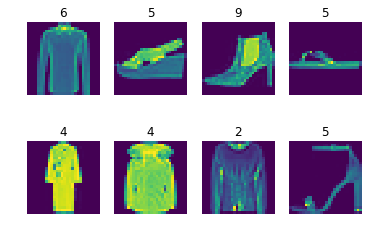

In [12]:
#lets visualize few images 
sample = np.random.randint(0,high= 59999, size=8)
print(sample)
sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()


In [13]:
#Defining constants
epochs = 5
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [14]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [15]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 14, 14, 64)    3200        input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_18 (BatchNor (None, 14, 14, 64)    256         conv2d_21[0][0]                  
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 14, 14, 64)    0           batch_normalization_18[0][0]     
___________________________________________________________________________________________

In [16]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

/kaggle/working/saved_model/fmnist_resnet_model.h5


In [ ]:
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Not using data augmentation.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
39000/60000 [==================>...........] - ETA: 823s - loss: 1.1548 - acc: 0.8278

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])